<a href="https://colab.research.google.com/github/it20652746/Task-Management/blob/main/PP2_IT20652746_Knowledge_based_food_recommendat_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

example = None


def get_recommended_calories(weight_kg, height_m, age, activity_level, pregnancy_stage):
    """
    Recommend daily calorie intake for pregnancy.

    Args:
    - weight_kg: Current weight in kilograms.
    - height_m: Current height in meters.
    - age: Age in years.
    - activity_level: Activity level (sedentary, lightly active, moderately active, very active).
    - pregnancy_stage: Stage of pregnancy (e.g., first trimester, second trimester, third trimester).

    Returns:
    - Recommended daily calorie intake for pregnancy.
    """

    # Calculate Basal Metabolic Rate (BMR) using the Harris-Benedict equation
    bmr = 447.593 + (9.247 * weight_kg) + (3.098 * height_m * 100) - (4.330 * age)

    # Adjust BMR based on activity level
    activity_levels = {
        'sedentary': 1.2,
        'lightly active': 1.375,
        'moderately active': 1.55,
        'very active': 1.725
    }

    if activity_level in activity_levels:
        bmr *= activity_levels[activity_level]

    # Adjust BMR for pregnancy stage
    pregnancy_factors = {
        'first trimester': 1.0, #Months 1-3
        'second trimester': 1.1, #Months 4-6
        'third trimester': 1.2 #Months 7-9
    }

    if pregnancy_stage in pregnancy_factors:
        bmr *= pregnancy_factors[pregnancy_stage]

    # Additional considerations for more accurate recommendations (consult with a healthcare th provider for these values must provide by user ):
    if pregnancy_stage == 'first trimester':
        additional_calories = 0
    elif pregnancy_stage == 'second trimester':
        additional_calories = 300  # Example value, consult for personalized recommendation
    elif pregnancy_stage == 'third trimester':
        additional_calories = 450  # Example value, consult for personalized recommendation
    else:
        additional_calories = 0

    # Calculate recommended calorie intake for pregnancy
    calorie_intake = bmr + additional_calories

    return calorie_intake

def get_processed_dataset(filters):
    data = pd.read_csv('/content/Sri_Lankan_Foods_Updated.csv')
    data = data.fillna(0)

    # Convert boolean columns to 1 / 0 values (prevent from being float values)
    int_columns = [
        'is_rice', 'is_curry', 'is_non_veg',
        'contains_peanuts', 'contains_milk', 'contains_eggs',
        'contains_shellfish', 'contains_fish', 'contains_soywheat',
        'contains_pork', 'contains_mutton', 'contains_beef', 'contains_chicken'
    ]
    data[int_columns] = data[int_columns].astype(int)

    # Extract numeric value from serving_size and convert to float
    data['serving_size'] = data['serving_size'].astype(str).str.extract('(\d+)').astype(float)

    # Normalization
    data['ratio'] = 100 / data['serving_size']
    cols_to_normalize = ['carbohydrate','total_fat','calories','protein']

    for col in cols_to_normalize:
        # Extract numeric part from the column and convert it to float
        data[col] = data[col].astype(str).str.extract('(\d+)').astype(float)
        # Multiply by ratio to normalize
        data[col] = data[col] * data['ratio']
    data['serving_size']=100.00

     # Apply Veg Filter
    if filters['is_vegetarian'] == True:
        data = data[data['is_non_veg'] == 0] # extract only veg food

    # Apply allergy filter
    for allergy, is_allergic in filters['allergies'].items():
        if is_allergic:
            data = data[data[f'contains_{allergy}'] == 0]

    required_cols = ['name','serving_size','carbohydrate','total_fat','calories','protein', 'is_curry', 'is_rice']

    global example
    example = data[required_cols]

    return data[required_cols]

# Get the protein carbohydrate fat gram values based on the calory requirement
def get_required_nutrient_grams(weight_kg, recommended_calories):
    # Calculate the calories from protein based on the weight in kilograms (1 kg = 4 calories of protein)
    protein_calories = weight_kg * 4

    # Calculate the remaining calories after accounting for protein calories
    res_calories = recommended_calories - protein_calories

    # Calculate the calories from carbohydrates as half of the total calories
    carb_calories = recommended_calories / 2.0

    # Calculate the calories from fat by subtracting protein and carbohydrate calories from the total
    fat_calories = recommended_calories - carb_calories - protein_calories

    protein_grams = protein_calories/4
    carb_grams = carb_calories/4
    fat_grams = fat_calories/9

    return protein_grams, carb_grams, fat_grams

# Genetic algorithm
def genetic_algorithm(food_data_set, required_nutrient_grams):

    pg, cg, fg = required_nutrient_grams
    pg, cg, fg = pg/3, cg/3, fg/3 # Since 3 meals


    random_rows = None
    food_names = None
    food_protein = None
    food_carbohydrate = None
    food_fat = None
    number_of_food_items_per_meal = 3

    # get a set of random food items
    def get_random_rows(dataframe, num_rows):
        random_indices = np.random.choice(dataframe.index, size=num_rows, replace=False)
        random_rows = dataframe.loc[random_indices]

        if (random_rows['is_curry'] == 1).any() and not (random_rows['is_rice'] == 1).any():
            random_rows = random_rows.append(dataframe[dataframe['is_rice'] == 1].sample())

        if (random_rows['is_rice'] == 1).any() and not (random_rows['is_curry'] == 1).any():
            random_rows = random_rows.append(dataframe[dataframe['is_curry'] == 1].sample())

        return random_rows

    # Get a random solution for the first generation
    def get_random_solution(num_of_variables):
        # itly, soya milk, rice
        # 30g, 40g, 100g
        sol = [round(random.uniform(0, 1), 6) for _ in range(num_of_variables)]
        return sol

    # Functions for protein, carb, fat
    def get_results(weights):
        protein_sum = sum(food_protein * weight for food_protein, weight in zip(food_protein, weights)) - pg
        carbs_sum = sum(food_carbohydrate * weight for food_carbohydrate, weight in zip(food_carbohydrate, weights)) - cg
        fats_sum = sum(food_fat * weight for food_fat, weight in zip(food_fat, weights)) - fg
        return protein_sum, carbs_sum, fats_sum

    # Get fitness value using the above 3 equation
    def get_fitness_val(weights):
        ans1, ans2, ans3 = get_results(weights)

        if ans1 == 0 and ans2==0 and ans3==0:
            return 999999
        else:
            return 1/(abs(ans1)+abs(ans2)+abs(ans3))

    # Function to run genetic algorithm for a random food set and get optimum weights
    def get_a_solution_with_genetic_algorithm():
        num_of_generations = 1000   # Change this if you want to change the number of iteration in genetic algorithm
        num_of_food = len(food_names)
        solutions = []
        fitness_score_history = []

        # get 1000 random inputs
        for s in range(1000):
            solutions.append(get_random_solution(num_of_food))

        # run 1000 generations
        for i in range(num_of_generations):
            rankedsolutions = []

            # get fitness values for 1000 input sets and sort
            for s in solutions:
                rankedsolutions.append((get_fitness_val(s),s))
            rankedsolutions.sort(reverse=True)

            fitness_score_history.append(rankedsolutions[0][0]) # store the best fitness value in the history

            # print(f" === Gen {i} best solutions === ")
            # print(rankedsolutions[0])

            # stop the algorithm if fitness score is good
            if rankedsolutions[0][0] > 20: # 1/20 = 0.05 -> therefore allow 0.05 for total error sum
                return rankedsolutions[0], fitness_score_history

            # otherwise get top 100 solutions
            bestsolutions = rankedsolutions[:100]

            elements = [[] for _ in range(num_of_food)]

            for s in bestsolutions:
                for p in range(num_of_food):
                  elements[p].append(s[1][p])

            # create new generation
            newGen = []
            for _ in range(1000):
                ll = [round(random.choice(elements[p]) * random.uniform(0.99, 1.01), 6) for p in range(num_of_food)]
                newGen.append(tuple(ll))

            solutions = newGen

            # stop after 1000 loops
            if i == num_of_generations - 1:
                return rankedsolutions[0], fitness_score_history

    def run():
        nonlocal random_rows, food_names, food_protein, food_carbohydrate, food_fat
        results_list = []
        i = 0
        while len(results_list) < 6: # We need 6 results because 3 meals per day, 2 suggestions per meal
            print("-----------------------------------------------")
            print(f"Running for random food set {i}")
            random_rows = get_random_rows(food_data_set, number_of_food_items_per_meal) # get random food set

            food_names = random_rows['name'].tolist()
            food_protein = random_rows['protein'].tolist()
            food_carbohydrate = random_rows['carbohydrate'].tolist()
            food_fat = random_rows['total_fat'].tolist()

            ans, plot_data = get_a_solution_with_genetic_algorithm()  # get answer using genetic algorithm
            if ans[0] >= 0.1: # Only add to results if fitness score is higher than 0.1 (maximum error: 1/0.1 = 10 g)
                results_list.append({
                    "foods": food_names,
                    "weights": [weight * 100 for weight in ans[1]], # convert to grams
                    "protein": food_protein,
                    "carbs": food_carbohydrate,
                    "fat": food_fat,
                    # "pp": (get_results(ans[1])[0] + pg)*100/pg,
                    # "cp": (get_results(ans[1])[1] + cg)*100/cg,
                    # "fp": (get_results(ans[1])[2] + fg)*100/fg,
                    # "total_protein": get_results(ans[1])[0] + pg,
                    # "total_carbs": get_results(ans[1])[1] + cg,
                    # "total_fat": get_results(ans[1])[2] + fg,
                    # "fitness": ans[0],
                    # "result_values": { get_results(ans[1])[0]+pg, get_results(ans[1])[1]+cg, get_results(ans[1])[2]+fg }
                })
                print(f"Fitness score {ans[0]}.")
                print(f"Fulfills {(get_results(ans[1])[0] + pg)*100/pg:.2f}% of protein requirement, {(get_results(ans[1])[1] + cg)*100/cg:.2f}% of carbohydrate requirement, {(get_results(ans[1])[2] + fg)*100/fg:.2f}% of fat requirement.")
            else:
                print("Not successful")
            i += 1

            # Plot fitness score history
            plt.figure()
            plt.plot(range(len(plot_data)), plot_data)
            plt.xlabel("Iterations")
            plt.ylabel("Fitness Score")
            plt.title("Fitness Score History")
            plt.grid(True)
            plt.show()

            print("-----------------------------------------------")
            print(f"Need {6 - len(results_list)} more good results")


        # data = []
        # for result in results_list:
        #     row_data = {'fitness_score': result['fitness']}
        #     for i, food in enumerate(result['foods']):
        #         row_data[f'food {i + 1} name'] = food
        #         row_data[f'food {i + 1} weight'] = result['weights'][i]
        #     row_data['sum_of_weights'] = sum(result['weights'])
        #     row_data["total_protein"] = result["total_protein"]
        #     row_data["total_carbs"] = result["total_carbs"]
        #     row_data["total_fat"] = result["total_fat"]
        #     row_data["req_protein"] = pg
        #     row_data["req_carbs"] = cg
        #     row_data["req_fat"] = fg
        #     data.append(row_data)

        # # Creating the DataFrame
        # df = pd.DataFrame(data)
        # df = df.sort_values(by=['fitness_score', 'sum_of_weights'], ascending=[False, True])


        json_res = []
        for entry in results_list:
            temp_list = []
            for food, weight in zip(entry["foods"], entry["weights"]):
                temp_list.append({"food": food, "weight": weight})
            json_res.append(temp_list)

        json_res_updated = {
            "breakfast": [json_res[0], json_res[3]],
            "lunch": [json_res[1], json_res[4]],
            "dinner": [json_res[2], json_res[5]]
        }

        return json_res_updated

    json_res = run()
    return json_res

# Get suggested meals
def get_meals(weight_kg, height_m, age, activity_level, pregnancy_stage, filters):
    food_data_set = get_processed_dataset(filters)  # get filtered dataset
    recommended_calories = get_recommended_calories(weight_kg, height_m, age, activity_level, pregnancy_stage) # get required calories
    required_nutrient_grams = get_required_nutrient_grams(weight_kg, recommended_calories)  # get required protein carbs fats
    dff = genetic_algorithm(food_data_set, required_nutrient_grams) # get results

    return dff


-----------------------------------------------
Running for random food set 0
Not successful


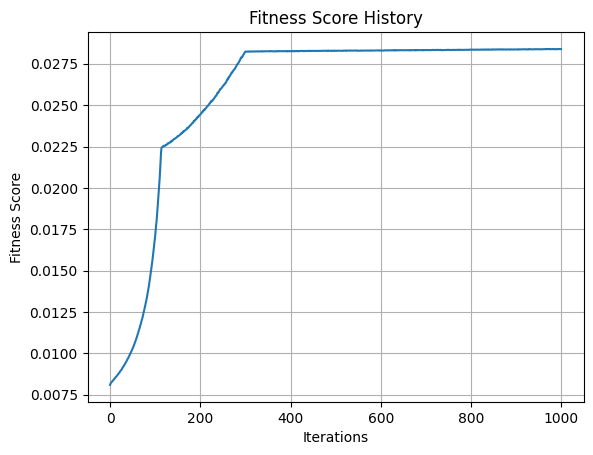

-----------------------------------------------
Need 6 more good results
-----------------------------------------------
Running for random food set 1
Not successful


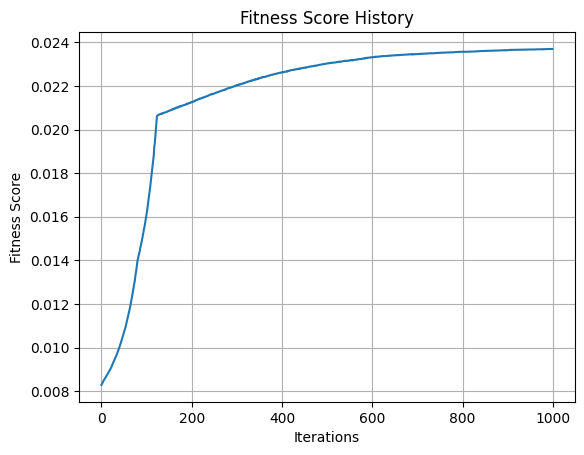

-----------------------------------------------
Need 6 more good results
-----------------------------------------------
Running for random food set 2
Not successful


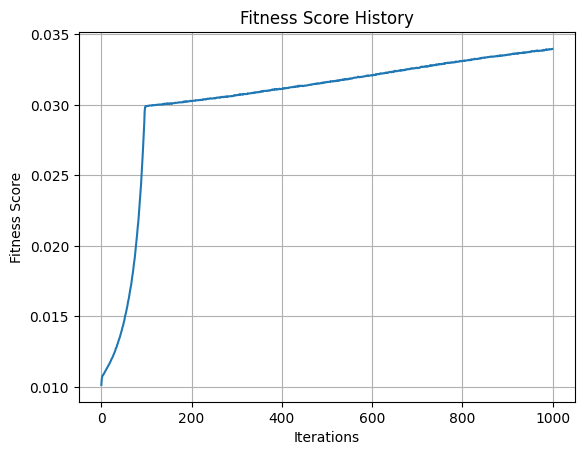

-----------------------------------------------
Need 6 more good results
-----------------------------------------------
Running for random food set 3
Fitness score 0.11259402577553601.
Fulfills 100.25% of protein requirement, 100.00% of carbohydrate requirement, 76.79% of fat requirement.


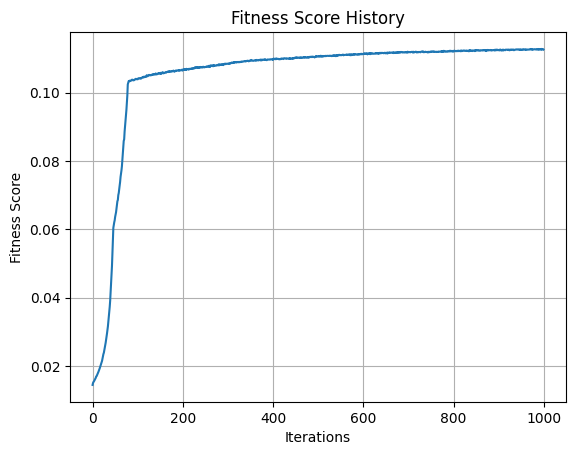

-----------------------------------------------
Need 5 more good results
-----------------------------------------------
Running for random food set 4
Not successful


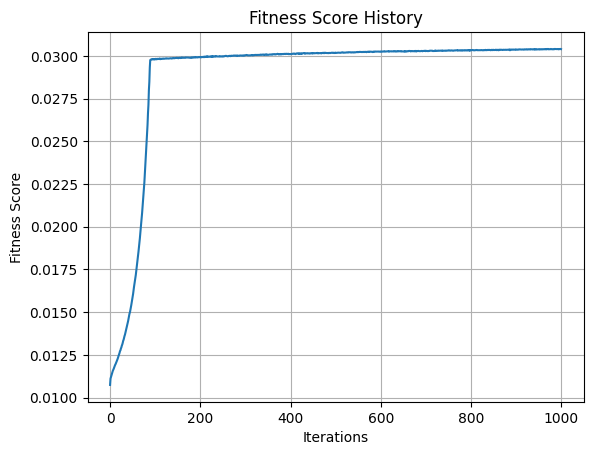

-----------------------------------------------
Need 5 more good results
-----------------------------------------------
Running for random food set 5
Fitness score 1.0926735170770419.
Fulfills 96.20% of protein requirement, 100.01% of carbohydrate requirement, 99.94% of fat requirement.


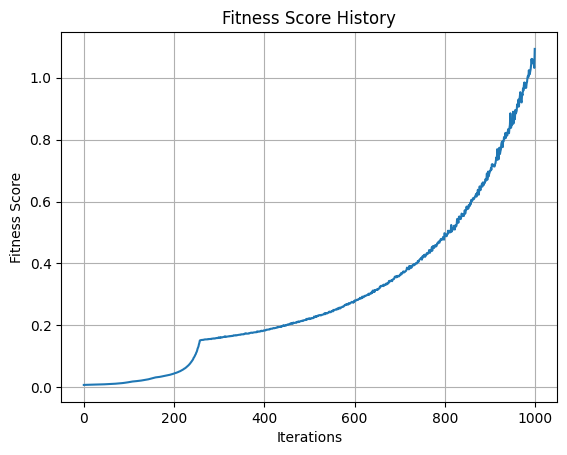

-----------------------------------------------
Need 4 more good results
-----------------------------------------------
Running for random food set 6
Fitness score 41.136925383771036.
Fulfills 99.98% of protein requirement, 100.01% of carbohydrate requirement, 99.97% of fat requirement.


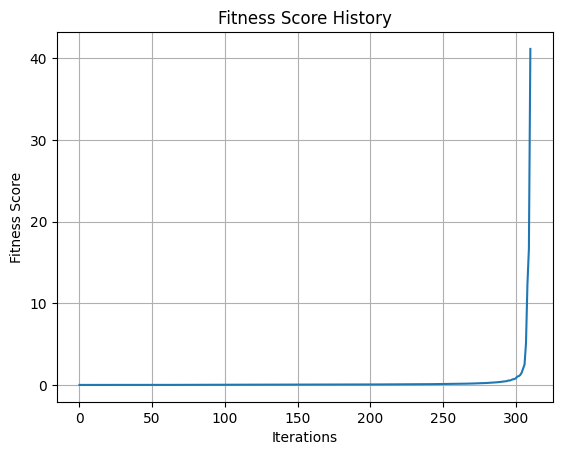

-----------------------------------------------
Need 3 more good results
-----------------------------------------------
Running for random food set 7
Not successful


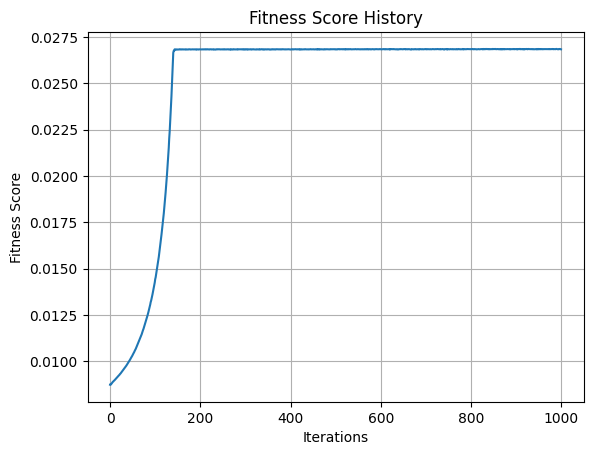

-----------------------------------------------
Need 3 more good results
-----------------------------------------------
Running for random food set 8
Not successful


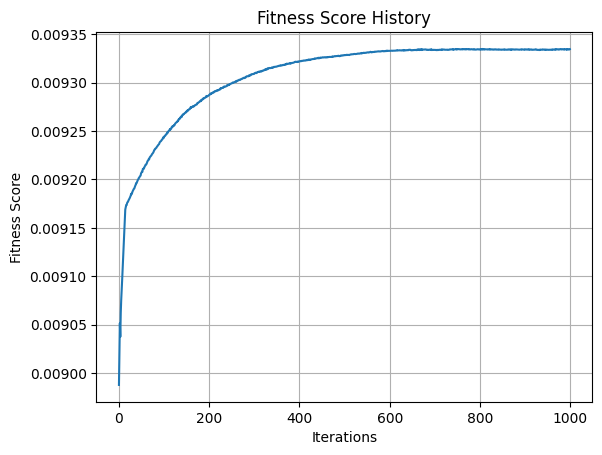

-----------------------------------------------
Need 3 more good results
-----------------------------------------------
Running for random food set 9
Not successful


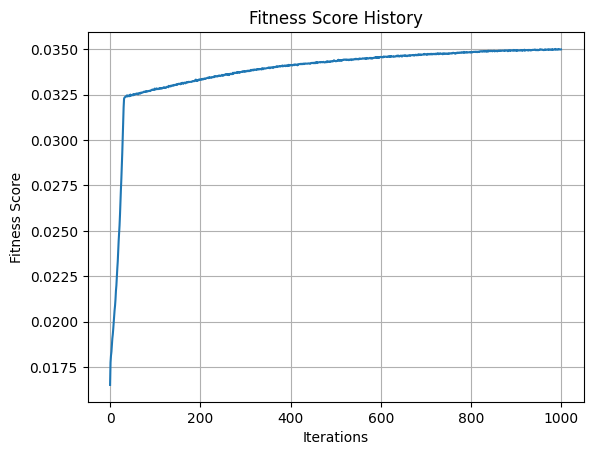

-----------------------------------------------
Need 3 more good results
-----------------------------------------------
Running for random food set 10
Fitness score 0.1679728638998515.
Fulfills 100.00% of protein requirement, 99.98% of carbohydrate requirement, 84.39% of fat requirement.


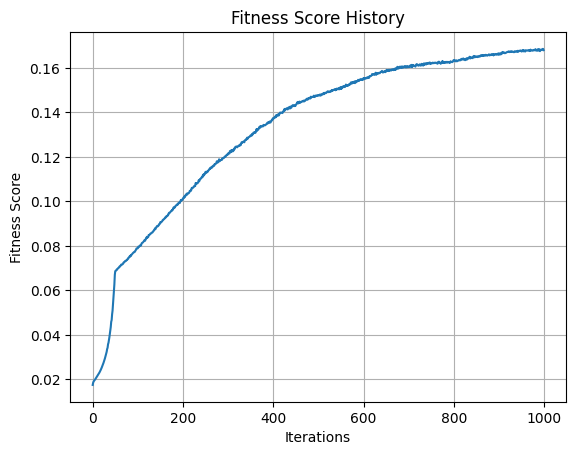

-----------------------------------------------
Need 2 more good results
-----------------------------------------------
Running for random food set 11
Not successful


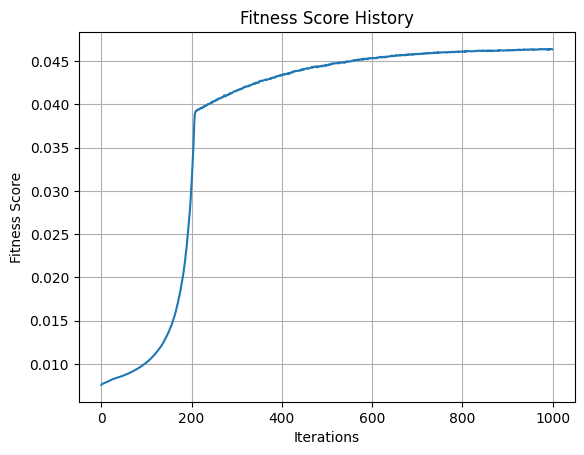

-----------------------------------------------
Need 2 more good results
-----------------------------------------------
Running for random food set 12
Not successful


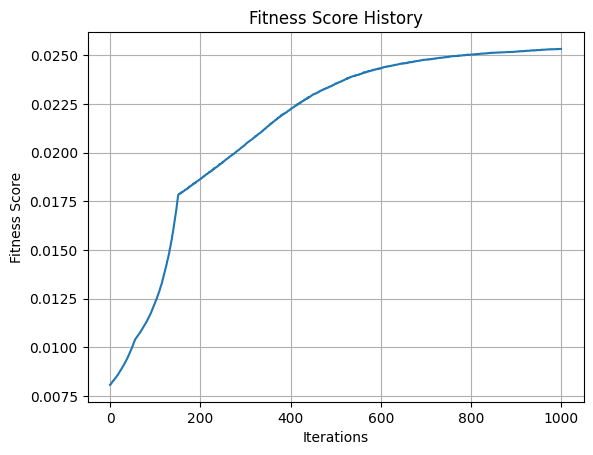

-----------------------------------------------
Need 2 more good results
-----------------------------------------------
Running for random food set 13
Fitness score 0.21375010709214412.
Fulfills 119.81% of protein requirement, 99.98% of carbohydrate requirement, 100.10% of fat requirement.


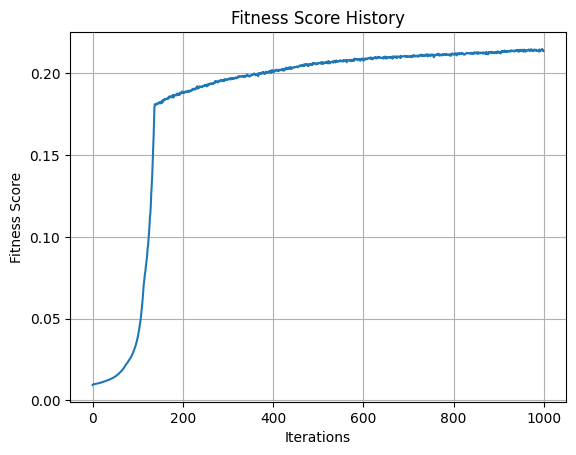

-----------------------------------------------
Need 1 more good results
-----------------------------------------------
Running for random food set 14
Not successful


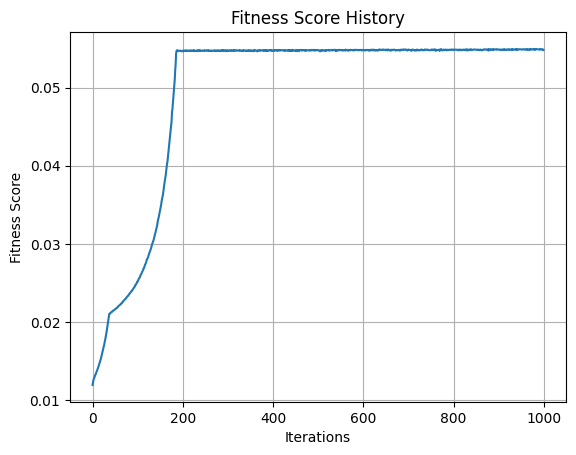

-----------------------------------------------
Need 1 more good results
-----------------------------------------------
Running for random food set 15
Not successful


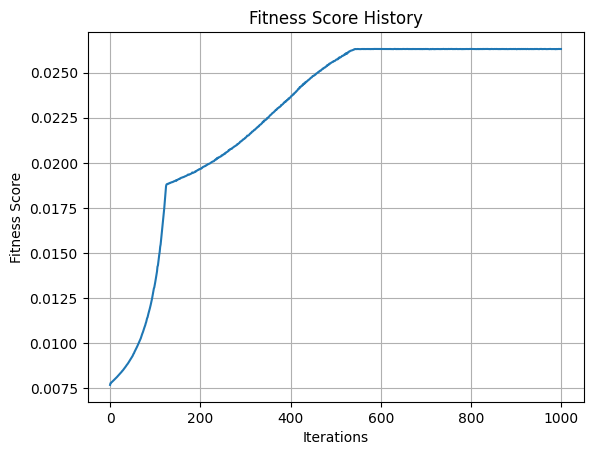

-----------------------------------------------
Need 1 more good results
-----------------------------------------------
Running for random food set 16
Fitness score 1.521459679360021.
Fulfills 97.36% of protein requirement, 100.02% of carbohydrate requirement, 99.96% of fat requirement.


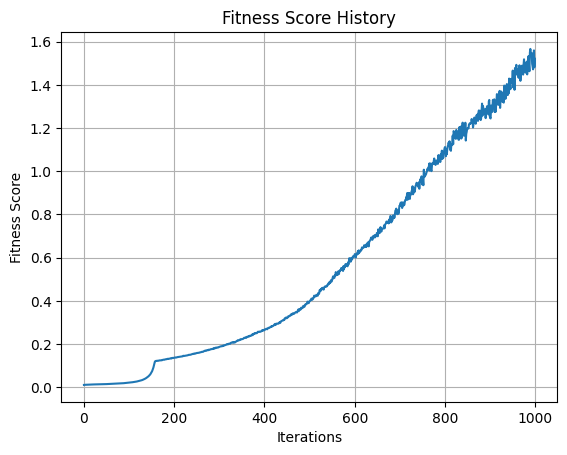

-----------------------------------------------
Need 0 more good results

{'breakfast': [[{'food': 'Dandina Ala Wandu', 'weight': 118.35640000000001}, {'food': 'Pizza_ frozen thin crust cheese topping', 'weight': 198.0623}, {'food': 'Cabbage without salt drained boiled_ chinese (pak-choi)', 'weight': 12.6055}], [{'food': 'Brussels sprouts without salt drained boiled ', 'weight': 7.8347}, {'food': 'Fish_ Pacific_herring', 'weight': 95.62950000000001}, {'food': 'Dandina Ala Wandu', 'weight': 237.7554}, {'food': 'RICE unenriched glutinous white', 'weight': 6.1227}]], 'lunch': [[{'food': 'Okra without salt drained boiled_ frozen', 'weight': 117.6459}, {'food': 'Purslane_ drained boiled ', 'weight': 1652.1787}, {'food': 'Polos Cutlet', 'weight': 261.1372}], [{'food': 'Mustard greens_ drained boiled_ frozen', 'weight': 15.453600000000002}, {'food': 'Dandina Ala Porridge', 'weight': 317.03450000000004}, {'food': 'Beans without salt boiled_ mature seeds royal red kidney', 'weight': 236.7261}]]

In [ ]:
# TODO: remove the warning
import warnings
# Filter FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

weight_kg = 70  # kg
height_m = 1.75  # meters
age = 25  # years
activity_level = 'lightly active'
pregnancy_stage = 'second trimester'

filters = {
    "is_vegetarian": False, # for this, there should be a column named is_non_veg (1 is non veg, 0 is veg)
    "allergies": {
        "peanuts": False,
        "fish": False,  # for this, there should be a column named contains_fish (1 is contains fish, 0 if doesn't contain fish)
        "milk": False,
        "eggs": False,
        "shellfish": False,
        "soywheat": False,
        "pork": False,
        "mutton": False,
        "beef": False,
        "chicken": False,
    }
}

res = get_meals(weight_kg, height_m, age, activity_level, pregnancy_stage, filters)

print()
print(res)

In [ ]:
res

# items per meal = 3 or 4
# choices per meal = 2

{'breakfast': [[{'food': 'Dandina Ala Wandu', 'weight': 118.35640000000001},
   {'food': 'Pizza_ frozen thin crust cheese topping', 'weight': 198.0623},
   {'food': 'Cabbage without salt drained boiled_ chinese (pak-choi)',
    'weight': 12.6055}],
  [{'food': 'Brussels sprouts without salt drained boiled ', 'weight': 7.8347},
   {'food': 'Fish_ Pacific_herring', 'weight': 95.62950000000001},
   {'food': 'Dandina Ala Wandu', 'weight': 237.7554},
   {'food': 'RICE unenriched glutinous white', 'weight': 6.1227}]],
 'lunch': [[{'food': 'Okra without salt drained boiled_ frozen',
    'weight': 117.6459},
   {'food': 'Purslane_ drained boiled ', 'weight': 1652.1787},
   {'food': 'Polos Cutlet', 'weight': 261.1372}],
  [{'food': 'Mustard greens_ drained boiled_ frozen',
    'weight': 15.453600000000002},
   {'food': 'Dandina Ala Porridge', 'weight': 317.03450000000004},
   {'food': 'Beans without salt boiled_ mature seeds royal red kidney',
    'weight': 236.7261}]],
 'dinner': [[{'food': 'O

In [ ]:
# to check the filtered dataset

example

,name,serving_size,carbohydrate,total_fat,calories,protein,is_curry,is_rice
0,Mung Wade,100.0,24.000000,40.000000,510.000000,12.000000,0,0
1,Mung milk rice with Lunumiris,100.0,21.333333,4.666667,142.000000,4.000000,0,0
2,Boiled Green gram with Lunumiris and Scraped C...,100.0,14.000000,3.666667,115.000000,7.000000,1,0
3,Boiled pulses pack & Lunumiris,100.0,14.545455,2.181818,104.363636,6.909091,0,0
4,Boiled Cowpea with Lunumiris & Scraped Coconut,100.0,12.333333,3.666667,114.000000,7.333333,0,0
...,...,...,...,...,...,...,...,...
883,Cereals without salt with water (includes boi...,100.0,12.000000,1.000000,71.000000,2.000000,0,0
884,Pork pan-broiled lean,100.0,0.000000,5.000000,169.000000,28.000000,1,0
885,Pork broiled lean,100.0,0.000000,5.000000,170.000000,29.000000,1,0
886,Pork lean and fat,100.0,0.000000,14.000000,235.000000,26.000000,1,0
